# local spark setup with ipython

## prerequisite：

> ipython in your local PC, [anaconda](https://www.anaconda.com/download/) recommended

> spark in your local PC, extracted to directory. [Download page](https://spark.apache.org/downloads.html)

> Powershell (For Windows)

## command to run

1. initialize ipython from your cmd
```bat
jupyter notebook
```

2. install packages if required (findspark for example)
```bat
pip install findspark
```

In [1]:
# important: please modify the path as your local spark location 
spark_path = "D:/spark-2.3.1-bin-hadoop2.7"

In [2]:
# configure spark, a message regrads time will print out if success
import findspark
from datetime import datetime
findspark.init("D:/spark-2.3.1-bin-hadoop2.7")
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster("local").setAppName("ibm_hr")
sc = SparkContext(conf = conf)
print("spark is well set at " + str(datetime.now()))

spark is well set at 2018-07-29 09:45:41.774597


In [3]:
# open spark session
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
spark = SparkSession(sc)
spark

# Exploratory Data Analysis


## Disclaimer: 
* for academic use only
* data is available on [Kaggle](https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset/kernels)
* most of the analysis pipeline in this notebook is referenced from this [kernel](https://www.kaggle.com/arthurtok/employee-attrition-via-rf-gbm). I do not own the copyright. For use other than academic, please contact with original author.

### Data loading and quality check
* findout if data is loaded correctly
* check if there is any null in any columns
* Get familar with our target: Attrition

In [4]:
# load dataset
ibm_hr = spark.read.csv("../data/WA_Fn-UseC_-HR-Employee-Attrition.csv", header=True, mode="DROPMALFORMED")
ibm_hr.show()

+---+---------+-----------------+---------+--------------------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+--------------------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|Attrition|   BusinessTravel|DailyRate|          Department|DistanceFromHome|Education|EducationField|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|             JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalanc

In [5]:
# check if there is any null value
from pyspark.sql.functions import isnan, when, count, col
ibm_hr.select([count(when(isnan(c), c)).alias(c) for c in ibm_hr.columns]).show()

+---+---------+--------------+---------+----------+----------------+---------+--------------+-------------+--------------+-----------------------+------+----------+--------------+--------+-------+---------------+-------------+-------------+-----------+------------------+------+--------+-----------------+-----------------+------------------------+-------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|Attrition|BusinessTravel|DailyRate|Department|DistanceFromHome|Education|EducationField|EmployeeCount|EmployeeNumber|EnvironmentSatisfaction|Gender|HourlyRate|JobInvolvement|JobLevel|JobRole|JobSatisfaction|MaritalStatus|MonthlyIncome|MonthlyRate|NumCompaniesWorked|Over18|OverTime|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StandardHours|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalance|YearsAtCompany|YearsInCurrentRole|YearsSinceLastPr

In [6]:
ibm_hr.select("Attrition").show()

+---------+
|Attrition|
+---------+
|      Yes|
|       No|
|      Yes|
|       No|
|       No|
|       No|
|       No|
|       No|
|       No|
|       No|
|       No|
|       No|
|       No|
|       No|
|      Yes|
|       No|
|       No|
|       No|
|       No|
|       No|
+---------+
only showing top 20 rows



### Transform and some viz
* generating numerical column for Attrition
* plot correlation matrix for some numerical columns

In [7]:
from pyspark.sql.functions import udf
from pyspark.sql.types import *
# define function to transform boolean
def bool_to_int(b):
    if b == "Yes":
        return 1
    else:
        return 0
# register user defined function with spark SQL
udf_bool_to_int = udf(bool_to_int, IntegerType())
# add column
ibm_hr_target = ibm_hr.withColumn("Attrition_numerical", udf_bool_to_int("Attrition"))
# check the result
ibm_hr_target.select("Attrition", "Attrition_numerical").show()

+---------+-------------------+
|Attrition|Attrition_numerical|
+---------+-------------------+
|      Yes|                  1|
|       No|                  0|
|      Yes|                  1|
|       No|                  0|
|       No|                  0|
|       No|                  0|
|       No|                  0|
|       No|                  0|
|       No|                  0|
|       No|                  0|
|       No|                  0|
|       No|                  0|
|       No|                  0|
|       No|                  0|
|      Yes|                  1|
|       No|                  0|
|       No|                  0|
|       No|                  0|
|       No|                  0|
|       No|                  0|
+---------+-------------------+
only showing top 20 rows



In [8]:
# preparation to compute a "small" correlation matrix for demostration
from pyspark.ml.stat import Correlation
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import col
# the list can be changed on your own preference
numerical_list = [u'Age', u'DailyRate', u'DistanceFromHome', u'Education', u'EmployeeNumber', u'EnvironmentSatisfaction']
ibm_hr_target_small = ibm_hr_target.select(numerical_list)
# cast all string values in df to int
ibm_hr_target_small = ibm_hr_target_small.select([col(c).cast(IntegerType()) for c in ibm_hr_target_small.columns])
ibm_hr_target_small.show()

+---+---------+----------------+---------+--------------+-----------------------+
|Age|DailyRate|DistanceFromHome|Education|EmployeeNumber|EnvironmentSatisfaction|
+---+---------+----------------+---------+--------------+-----------------------+
| 41|     1102|               1|        2|             1|                      2|
| 49|      279|               8|        1|             2|                      3|
| 37|     1373|               2|        2|             4|                      4|
| 33|     1392|               3|        4|             5|                      4|
| 27|      591|               2|        1|             7|                      1|
| 32|     1005|               2|        2|             8|                      4|
| 59|     1324|               3|        3|            10|                      3|
| 30|     1358|              24|        1|            11|                      4|
| 38|      216|              23|        3|            12|                      4|
| 36|     1299| 

In [9]:
# check type
ibm_hr_target_small

DataFrame[Age: int, DailyRate: int, DistanceFromHome: int, Education: int, EmployeeNumber: int, EnvironmentSatisfaction: int]

In [10]:
# transform spark dataframe to pandas to print the image
import matplotlib.pyplot as plt
plt.matshow(ibm_hr_target_small.select("*").toPandas().corr())

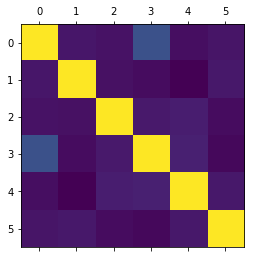

In [11]:
plt.show()

### spark original way to generate correlation

In [12]:
# calculating single correlation between two columns is also available, however quite difficult to viz by then
ibm_hr_target_small.stat.corr("Age", "DailyRate")

0.010660942645538433

## Feature Engineering & Categorical Encoding
Prepare data to do machine learning

### Get numerical data
Actually in a harding way.

In [13]:
# set list of numerical values
numerical = [u'Age', u'DailyRate', u'DistanceFromHome', u'Education', u'EmployeeNumber', u'EnvironmentSatisfaction', \
             u'HourlyRate', u'JobInvolvement', u'JobLevel', u'JobSatisfaction', \
             u'MonthlyIncome', u'MonthlyRate', u'NumCompaniesWorked', \
             u'PercentSalaryHike', u'PerformanceRating', u'RelationshipSatisfaction', \
             u'StockOptionLevel', u'TotalWorkingYears', \
             u'TrainingTimesLastYear', u'WorkLifeBalance', u'YearsAtCompany', \
             u'YearsInCurrentRole', u'YearsSinceLastPromotion', u'YearsWithCurrManager']
# drop numerical columns
ibm_hr_no_numerical = ibm_hr_target.drop(*numerical)

### Get categorical data
Different from the approach in the [Kaggle Kernel](https://www.kaggle.com/arthurtok/employee-attrition-via-rf-gbm), I need to select the categorical in a quite hard coding way as spark read all data type as **String**.

I manuly define those column with values **COUNT DISINCT** smaller than 20 as categorical.

In [14]:
# check the type of the columns
ibm_hr_no_numerical

DataFrame[Attrition: string, BusinessTravel: string, Department: string, EducationField: string, EmployeeCount: string, Gender: string, JobRole: string, MaritalStatus: string, Over18: string, OverTime: string, StandardHours: string, Attrition_numerical: int]

In [46]:
# set a list to store columns with categorical data type
categorical = []
for col in ibm_hr_no_numerical.columns:
    num_types = ibm_hr_no_numerical.select(col).distinct().count()
    print(col + " :" + str(num_types))
    if num_types < 20 and num_types != 1:
        categorical.append(col)
categorical

Attrition :2
BusinessTravel :3
Department :3
EducationField :6
EmployeeCount :1
Gender :2
JobRole :9
MaritalStatus :3
Over18 :1
OverTime :2
StandardHours :1
Attrition_numerical :2


['Attrition',
 'BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'OverTime',
 'Attrition_numerical']

In [47]:
# remove our target; note that we must use deep copy to ensure the originality of lists
import copy
categorical_no_target = copy.deepcopy(categorical)
categorical_no_target.remove("Attrition_numerical")
categorical_no_target.remove("Attrition")
categorical_no_target

['BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'OverTime']

In [48]:
# get categorical dataframe
ibm_hr_cat = ibm_hr_no_numerical.select(categorical_no_target)
ibm_hr_cat.show()

+-----------------+--------------------+--------------+------+--------------------+-------------+--------+
|   BusinessTravel|          Department|EducationField|Gender|             JobRole|MaritalStatus|OverTime|
+-----------------+--------------------+--------------+------+--------------------+-------------+--------+
|    Travel_Rarely|               Sales| Life Sciences|Female|     Sales Executive|       Single|     Yes|
|Travel_Frequently|Research & Develo...| Life Sciences|  Male|  Research Scientist|      Married|      No|
|    Travel_Rarely|Research & Develo...|         Other|  Male|Laboratory Techni...|       Single|     Yes|
|Travel_Frequently|Research & Develo...| Life Sciences|Female|  Research Scientist|      Married|     Yes|
|    Travel_Rarely|Research & Develo...|       Medical|  Male|Laboratory Techni...|      Married|      No|
|Travel_Frequently|Research & Develo...| Life Sciences|  Male|Laboratory Techni...|       Single|      No|
|    Travel_Rarely|Research & Develo.

### Attempt to get dummny in a spark way
Reference can be found at [here](https://stackoverflow.com/questions/42805663/e-num-get-dummies-in-pyspark).

Although the program produces the desired result, it takes considerable amount of time, which discourages me from reproducing this on my dataframe.

In [107]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
import pyspark.sql.functions as F
df = sqlContext.createDataFrame([
    (1, "A", "X1"),
    (2, "B", "X2"),
    (3, "B", "X3"),
    (1, "B", "X3"),
    (2, "C", "X2"),
    (3, "C", "X2"),
    (1, "C", "X1"),
    (1, "B", "X1"),
], ["ID", "TYPE", "CODE"])

types = df.select("TYPE").distinct().rdd.flatMap(lambda x: x).collect()
codes = df.select("CODE").distinct().rdd.flatMap(lambda x: x).collect()
types_expr = [F.when(F.col("TYPE") == ty, 1).otherwise(0).alias("e_TYPE_" + ty) for ty in types]
codes_expr = [F.when(F.col("CODE") == code, 1).otherwise(0).alias("e_CODE_" + code) for code in codes]
df = df.select("ID", "TYPE", "CODE", *types_expr+codes_expr)
df.show()

+---+----+----+--------+--------+--------+---------+---------+---------+
| ID|TYPE|CODE|e_TYPE_B|e_TYPE_C|e_TYPE_A|e_CODE_X1|e_CODE_X3|e_CODE_X2|
+---+----+----+--------+--------+--------+---------+---------+---------+
|  1|   A|  X1|       0|       0|       1|        1|        0|        0|
|  2|   B|  X2|       1|       0|       0|        0|        0|        1|
|  3|   B|  X3|       1|       0|       0|        0|        1|        0|
|  1|   B|  X3|       1|       0|       0|        0|        1|        0|
|  2|   C|  X2|       0|       1|       0|        0|        0|        1|
|  3|   C|  X2|       0|       1|       0|        0|        0|        1|
|  1|   C|  X1|       0|       1|       0|        1|        0|        0|
|  1|   B|  X1|       1|       0|       0|        1|        0|        0|
+---+----+----+--------+--------+--------+---------+---------+---------+



Again, I turned to **Pandas** for help

In [109]:
# use pandas to get_dummies
import pandas as pd
pd_cat = pd.get_dummies(ibm_hr_cat.select("*").toPandas())
pd_cat.head(3)

,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,...,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,OverTime_No,OverTime_Yes
0,0,0,1,0,0,1,0,1,0,0,...,0,0,0,1,0,0,0,1,0,1
1,0,1,0,0,1,0,0,1,0,0,...,0,0,1,0,0,0,1,0,1,0
2,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [110]:
# convert back to spark dataframe
ibm_hr_cat_dum = spark.createDataFrame(pd_cat)
ibm_hr_cat_dum.show(3)

+-------------------------+--------------------------------+----------------------------+--------------------------+---------------------------------+----------------+------------------------------+----------------------------+------------------------+----------------------+--------------------+-------------------------------+-------------+-----------+---------------------------------+-----------------------+-----------------------------+---------------+------------------------------+-------------------------+--------------------------+-----------------------+----------------------------+----------------------+---------------------+--------------------+-----------+------------+
|BusinessTravel_Non-Travel|BusinessTravel_Travel_Frequently|BusinessTravel_Travel_Rarely|Department_Human Resources|Department_Research & Development|Department_Sales|EducationField_Human Resources|EducationField_Life Sciences|EducationField_Marketing|EducationField_Medical|EducationField_Other|EducationField_Te

### Concat the dataframe
This is where we are going to train and test our data on.

In [112]:
# get numerical features
ibm_hr_int = ibm_hr_target.select(numerical)
ibm_hr_int.show(3)

+---+---------+----------------+---------+--------------+-----------------------+----------+--------------+--------+---------------+-------------+-----------+------------------+-----------------+-----------------+------------------------+----------------+-----------------+---------------------+---------------+--------------+------------------+-----------------------+--------------------+
|Age|DailyRate|DistanceFromHome|Education|EmployeeNumber|EnvironmentSatisfaction|HourlyRate|JobInvolvement|JobLevel|JobSatisfaction|MonthlyIncome|MonthlyRate|NumCompaniesWorked|PercentSalaryHike|PerformanceRating|RelationshipSatisfaction|StockOptionLevel|TotalWorkingYears|TrainingTimesLastYear|WorkLifeBalance|YearsAtCompany|YearsInCurrentRole|YearsSinceLastPromotion|YearsWithCurrManager|
+---+---------+----------------+---------+--------------+-----------------------+----------+--------------+--------+---------------+-------------+-----------+------------------+-----------------+-----------------+-----

In [115]:
# Concat the two dataframes together columnwise
ibm_hr_final = ibm_hr_int.join(ibm_hr_cat_dum)
for c in ibm_hr_final.columns:
    ibm_hr_final = ibm_hr_final.withColumn(c, ibm_hr_final[c].cast(IntegerType()))
ibm_hr_final.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EmployeeNumber: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- PercentSalaryHike: integer (nullable = true)
 |-- PerformanceRating: integer (nullable = true)
 |-- RelationshipSatisfaction: integer (nullable = true)
 |-- StockOptionLevel: integer (nullable = true)
 |-- TotalWorkingYears: integer (nullable = true)
 |-- TrainingTimesLastYear: integer (nullable = true)
 |-- WorkLifeBalance: integer (nullable = true)
 |-- YearsAtCompany: integer (nullable = true

Unfortunately, plot is also difficult with *pyspark* in *jupyter notebook*.

Using *Zeppelin* might have a better result, but she does not works well with *Windows*.

So at here, I only do a brief stat on our target.

In [125]:
print("regarding attrition:")
print("Yes: " + str(ibm_hr.filter(ibm_hr['Attrition'] == "Yes").count()))
print("No: " + str(ibm_hr.filter(ibm_hr['Attrition'] == "No").count()))

regarding attrition:
Yes: 237
No: 1233


### Trial for user self-defined get dummny function
Reference can be found at [here](https://runawayhorse001.github.io/LearningApacheSpark/pyspark.pdf).

This should work with *pyspark*; however, the error is currently beyond my level.

In [102]:
# Concat the two dataframes together columnwise
ibm_hr_final2 = ibm_hr_final.join(ibm_hr.select("Attrition"))
ibm_hr_final2.printSchema()

root
 |-- Age: integer (nullable = true)
 |-- DailyRate: integer (nullable = true)
 |-- DistanceFromHome: integer (nullable = true)
 |-- Education: integer (nullable = true)
 |-- EmployeeNumber: integer (nullable = true)
 |-- EnvironmentSatisfaction: integer (nullable = true)
 |-- HourlyRate: integer (nullable = true)
 |-- JobInvolvement: integer (nullable = true)
 |-- JobLevel: integer (nullable = true)
 |-- JobSatisfaction: integer (nullable = true)
 |-- MonthlyIncome: integer (nullable = true)
 |-- MonthlyRate: integer (nullable = true)
 |-- NumCompaniesWorked: integer (nullable = true)
 |-- PercentSalaryHike: integer (nullable = true)
 |-- PerformanceRating: integer (nullable = true)
 |-- RelationshipSatisfaction: integer (nullable = true)
 |-- StockOptionLevel: integer (nullable = true)
 |-- TotalWorkingYears: integer (nullable = true)
 |-- TrainingTimesLastYear: integer (nullable = true)
 |-- WorkLifeBalance: integer (nullable = true)
 |-- YearsAtCompany: integer (nullable = true

In [94]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col
def get_dummy(df, categoricalCols, continuousCols, labelCol):
    indexers = [StringIndexer(inputCol = c, outputCol = "{0}_indexed".format(c)) for c in categoricalCols]
    # default setting: dropLast = True
    encoders = [OneHotEncoder(inputCol = indexer.getOutputCol(), \
                outputCol = "{0}_encoded".format(indexer.getOutputCol())) \
                for indexer in indexers]
    assembler = VectorAssembler(inputCols = [encoder.getOutputCol() for encoder in encoders] \
                + continuousCols, outputCol = "features")
    pipeline = Pipeline(stages=indexers + encoders + [assembler])
    model=pipeline.fit(df)
    data = model.transform(df)
    data = data.withColumn('label', col(labelCol))
    return data.select('features', 'label')

In [95]:
categorical_no_target

['BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'OverTime']

In [96]:
numerical

['Age',
 'DailyRate',
 'DistanceFromHome',
 'Education',
 'EmployeeNumber',
 'EnvironmentSatisfaction',
 'HourlyRate',
 'JobInvolvement',
 'JobLevel',
 'JobSatisfaction',
 'MonthlyIncome',
 'MonthlyRate',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'PerformanceRating',
 'RelationshipSatisfaction',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'WorkLifeBalance',
 'YearsAtCompany',
 'YearsInCurrentRole',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

In [98]:
label = "Attrition"
label

'Attrition'

In [103]:
data = get_dummy(ibm_hr_final2, categorical_no_target ,numerical, label)
data.show(5)

AnalysisException: 'Detected implicit cartesian product for INNER join between logical plans\nJoin Inner\n:- Project\n:  +- Relation[Age#10,Attrition#11,BusinessTravel#12,DailyRate#13,Department#14,DistanceFromHome#15,Education#16,EducationField#17,EmployeeCount#18,EmployeeNumber#19,EnvironmentSatisfaction#20,Gender#21,HourlyRate#22,JobInvolvement#23,JobLevel#24,JobRole#25,JobSatisfaction#26,MaritalStatus#27,MonthlyIncome#28,MonthlyRate#29,NumCompaniesWorked#30,Over18#31,OverTime#32,PercentSalaryHike#33,... 11 more fields] csv\n+- Project [BusinessTravel#12]\n   +- Filter AtLeastNNulls(n, BusinessTravel#12)\n      +- Relation[Age#10,Attrition#11,BusinessTravel#12,DailyRate#13,Department#14,DistanceFromHome#15,Education#16,EducationField#17,EmployeeCount#18,EmployeeNumber#19,EnvironmentSatisfaction#20,Gender#21,HourlyRate#22,JobInvolvement#23,JobLevel#24,JobRole#25,JobSatisfaction#26,MaritalStatus#27,MonthlyIncome#28,MonthlyRate#29,NumCompaniesWorked#30,Over18#31,OverTime#32,PercentSalaryHike#33,... 11 more fields] csv\nand\nProject\n+- Relation[Age#10,Attrition#11,BusinessTravel#12,DailyRate#13,Department#14,DistanceFromHome#15,Education#16,EducationField#17,EmployeeCount#18,EmployeeNumber#19,EnvironmentSatisfaction#20,Gender#21,HourlyRate#22,JobInvolvement#23,JobLevel#24,JobRole#25,JobSatisfaction#26,MaritalStatus#27,MonthlyIncome#28,MonthlyRate#29,NumCompaniesWorked#30,Over18#31,OverTime#32,PercentSalaryHike#33,... 11 more fields] csv\nJoin condition is missing or trivial.\nEither: use the CROSS JOIN syntax to allow cartesian products between these\nrelations, or: enable implicit cartesian products by setting the configuration\nvariable spark.sql.crossJoin.enabled=true;'